In [93]:
import os
from pathlib import Path
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from datetime import datetime

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score

TARGET       = "is_fraud" # la target du projet
TEST_SIZE     = 20/100 # le test size
RS  = 42 # le random state

### 🔍 📊 EDA

#### 🔍 Exploration de la donnée

In [94]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
df = pd.read_csv('data/fraudTest.csv')
display(df.head())

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [95]:
print(f"Shape : {df.shape:}")
print()
display(df.describe(include="all"))

Shape : (555719, 23)



,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,555719,5.557190e+05,555719,555719,555719.000000,555719,555719,555719,555719,555719,555719,555719.000000,555719.000000,555719.000000,5.557190e+05,555719,555719,555719,5.557190e+05,555719.000000,555719.000000,555719.000000
unique,NaN,544760,NaN,693,14,NaN,341,471,2,924,849,50,NaN,NaN,NaN,NaN,478,910,555719,NaN,NaN,NaN,NaN
top,NaN,2020-12-19 16:02:22,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,444 Robert Mews,Birmingham,TX,NaN,NaN,NaN,NaN,Film/video editor,1977-03-23,2da90c7d74bd46a0caf3777415b3ebd3,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,1859,56370,NaN,11443,12146,304886,1474,2423,40393,NaN,NaN,NaN,NaN,4119,2408,1,NaN,NaN,NaN,NaN
mean,277859.000000,NaN,4.178387e+17,NaN,NaN,69.392810,NaN,NaN,NaN,NaN,NaN,NaN,48842.628015,38.543253,-90.231325,8.822189e+04,NaN,NaN,NaN,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,NaN,1.309837e+18,NaN,NaN,156.745941,NaN,NaN,NaN,NaN,NaN,NaN,26855.283328,5.061336,13.721780,3.003909e+05,NaN,NaN,NaN,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,NaN,6.041621e+10,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1257.000000,20.027100,-165.672300,2.300000e+01,NaN,NaN,NaN,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,NaN,1.800429e+14,NaN,NaN,9.630000,NaN,NaN,NaN,NaN,NaN,NaN,26292.000000,34.668900,-96.798000,7.410000e+02,NaN,NaN,NaN,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,NaN,3.521417e+15,NaN,NaN,47.290000,NaN,NaN,NaN,NaN,NaN,NaN,48174.000000,39.371600,-87.476900,2.408000e+03,NaN,NaN,NaN,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,NaN,4.635331e+15,NaN,NaN,83.010000,NaN,NaN,NaN,NaN,NaN,NaN,72011.000000,41.894800,-80.175200,1.968500e+04,NaN,NaN,NaN,1.385867e+09,41.954163,-80.264637,0.000000


In [96]:
print("Valeurs manquantes :")
display(df.isna().mean() * 100)

nb_duplicated = df.duplicated().sum()
total_rows = len(df)

pourcentage = round((nb_duplicated / total_rows) * 100, 2)

print(f"{pourcentage} % de lignes dupliquées ({nb_duplicated} sur {total_rows})")

Valeurs manquantes :


Unnamed: 0               0.0
trans_date_trans_time    0.0
cc_num                   0.0
merchant                 0.0
category                 0.0
amt                      0.0
first                    0.0
last                     0.0
gender                   0.0
street                   0.0
city                     0.0
state                    0.0
zip                      0.0
lat                      0.0
long                     0.0
city_pop                 0.0
job                      0.0
dob                      0.0
trans_num                0.0
unix_time                0.0
merch_lat                0.0
merch_long               0.0
is_fraud                 0.0
dtype: float64

0.0 % de lignes dupliquées (0 sur 555719)


In [97]:
#calcul de l'age par rapport à la date de transaction
df["dob"] = pd.to_datetime(df["dob"], errors="coerce")

df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["age"] = (df["trans_date_trans_time"].dt.year - df["dob"].dt.year)
df = df.drop(columns=["dob"])
df["age"].describe()

count    555719.000000
mean         46.636237
std          17.418528
min          15.000000
25%          33.000000
50%          45.000000
75%          58.000000
max          96.000000
Name: age, dtype: float64

In [98]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["year"] = df["trans_date_trans_time"].dt.year
df["month"] = df["trans_date_trans_time"].dt.month
df["day_of_week"] = df["trans_date_trans_time"].dt.dayofweek
df["hour"] = df["trans_date_trans_time"].dt.hour
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df = df.drop(columns=["trans_date_trans_time"])
#display(df.head())

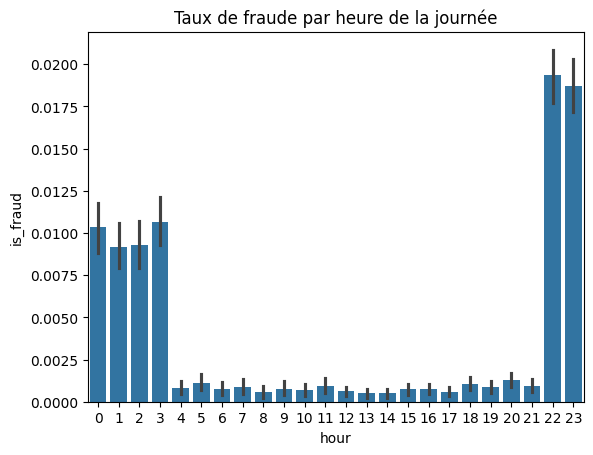

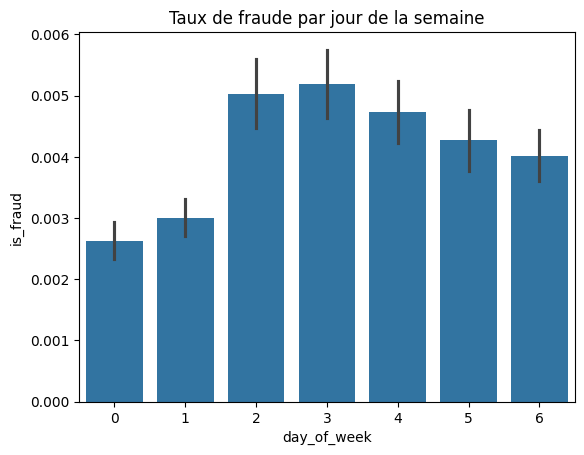

In [99]:
sns.barplot(data=df, x='hour', y='is_fraud')
plt.title("Taux de fraude par heure de la journée")
plt.show()

sns.barplot(data=df, x='day_of_week', y='is_fraud')
plt.title("Taux de fraude par jour de la semaine")
plt.show()

In [100]:
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

#### lat, long : latitude / longitude du client / carte bancaire (lieu d’origine de la transaction)
#### merch_lat, merch_long latitude / longitude du marchand (où la transaction a eu lieu)



In [101]:
# Distance entre client et marchand

def haversine_distance(lat1, lon1, lat2, lon2):
    # Rayon moyen de la Terre (km)
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["distance_km"] = haversine_distance(
    df["lat"], df["long"], df["merch_lat"], df["merch_long"]
)

df = df.drop(columns=["lat", "long", "merch_lat", "merch_long"])

display(df.head())

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,trans_num,unix_time,is_fraud,age,year,month,day_of_week,hour,is_weekend,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,333497,Mechanical engineer,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,0,52,2020,6,6,12,1,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,302,"Sales professional, IT",324cc204407e99f51b0d6ca0055005e7,1371816873,0,30,2020,6,6,12,1,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,34496,"Librarian, public",c81755dbbbea9d5c77f094348a7579be,1371816893,0,50,2020,6,6,12,1,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,54767,Set designer,2159175b9efe66dc301f149d3d5abf8c,1371816915,0,33,2020,6,6,12,1,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,1126,Furniture designer,57ff021bd3f328f8738bb535c302a31b,1371816917,0,65,2020,6,6,12,1,104.335106


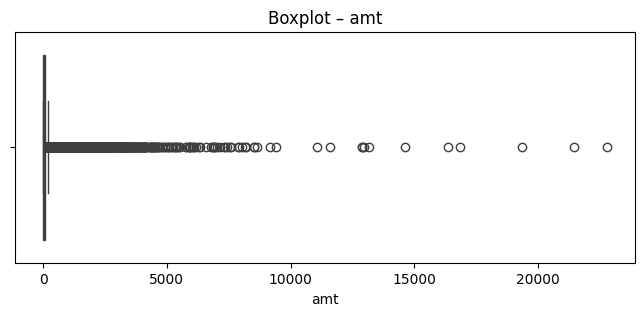

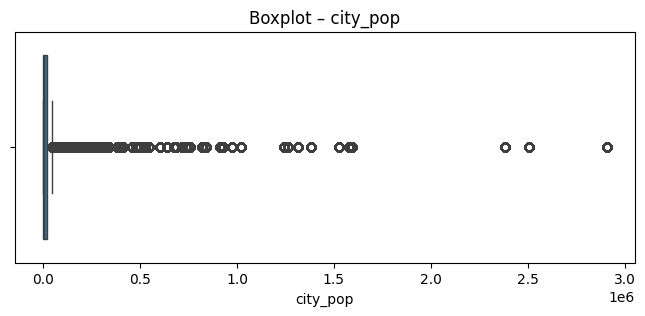

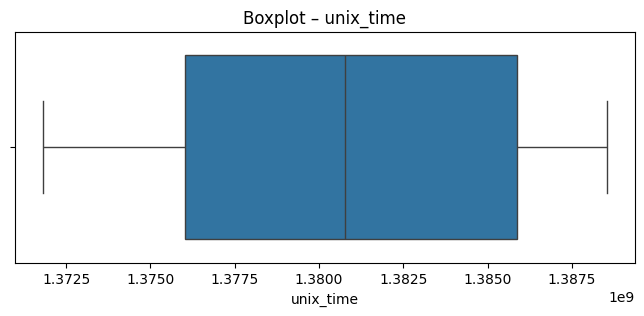

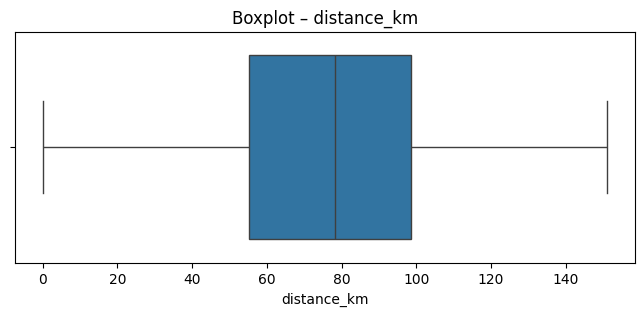

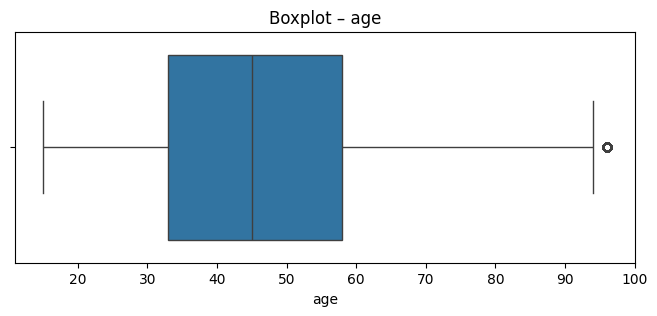

In [102]:
#outliers
numeric_cols = [
    "amt", "city_pop", "unix_time", "distance_km", "age"
]

for col in numeric_cols:
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot – {col}")
    plt.show()

In [103]:
display(df.describe(include="all"))

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,trans_num,unix_time,is_fraud,age,year,month,day_of_week,hour,is_weekend,distance_km
count,5.557190e+05,555719,555719,555719.000000,555719,555719,555719,555719,555719,555719,555719.000000,5.557190e+05,555719,555719,5.557190e+05,555719.000000,555719.000000,555719.0,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000
unique,NaN,693,14,NaN,341,471,2,924,849,50,NaN,NaN,478,555719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,444 Robert Mews,Birmingham,TX,NaN,NaN,Film/video editor,2da90c7d74bd46a0caf3777415b3ebd3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1859,56370,NaN,11443,12146,304886,1474,2423,40393,NaN,NaN,4119,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.178387e+17,NaN,NaN,69.392810,NaN,NaN,NaN,NaN,NaN,NaN,48842.628015,8.822189e+04,NaN,NaN,1.380679e+09,0.003860,46.636237,2020.0,9.508536,2.726779,12.809062,0.279580,76.104902
std,1.309837e+18,NaN,NaN,156.745941,NaN,NaN,NaN,NaN,NaN,NaN,26855.283328,3.003909e+05,NaN,NaN,5.201104e+06,0.062008,17.418528,0.0,1.978205,2.178681,6.810924,0.448793,29.117079
min,6.041621e+10,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1257.000000,2.300000e+01,NaN,NaN,1.371817e+09,0.000000,15.000000,2020.0,6.000000,0.000000,0.000000,0.000000,0.123883
25%,1.800429e+14,NaN,NaN,9.630000,NaN,NaN,NaN,NaN,NaN,NaN,26292.000000,7.410000e+02,NaN,NaN,1.376029e+09,0.000000,33.000000,2020.0,8.000000,1.000000,7.000000,0.000000,55.286255
50%,3.521417e+15,NaN,NaN,47.290000,NaN,NaN,NaN,NaN,NaN,NaN,48174.000000,2.408000e+03,NaN,NaN,1.380762e+09,0.000000,45.000000,2020.0,10.000000,2.000000,14.000000,0.000000,78.179517
75%,4.635331e+15,NaN,NaN,83.010000,NaN,NaN,NaN,NaN,NaN,NaN,72011.000000,1.968500e+04,NaN,NaN,1.385867e+09,0.000000,58.000000,2020.0,12.000000,5.000000,19.000000,1.000000,98.520760


In [104]:
df.dtypes

cc_num           int64
merchant        object
category        object
amt            float64
first           object
last            object
gender          object
street          object
city            object
state           object
zip              int64
city_pop         int64
job             object
trans_num       object
unix_time        int64
is_fraud         int64
age              int32
year             int32
month            int32
day_of_week      int32
hour             int32
is_weekend       int64
distance_km    float64
dtype: object

In [105]:

display(df.head())

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,trans_num,unix_time,is_fraud,age,year,month,day_of_week,hour,is_weekend,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,333497,Mechanical engineer,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,0,52,2020,6,6,12,1,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,302,"Sales professional, IT",324cc204407e99f51b0d6ca0055005e7,1371816873,0,30,2020,6,6,12,1,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,34496,"Librarian, public",c81755dbbbea9d5c77f094348a7579be,1371816893,0,50,2020,6,6,12,1,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,54767,Set designer,2159175b9efe66dc301f149d3d5abf8c,1371816915,0,33,2020,6,6,12,1,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,1126,Furniture designer,57ff021bd3f328f8738bb535c302a31b,1371816917,0,65,2020,6,6,12,1,104.335106


#### Remarques sur l'exploration de la donnée :  
- Nous avons à faire à une classification binaire avec un fort déséquilibre de classes
- la target "is_fraud" est fortement "imbalanced" : les is_fraud (valeur = 1) ne représentent que 0,39% du dataset (pour le modèle utiliser le stratify pendant la création du train et du test et utiliser un f1-score pour choisir le meilleur modèle)
- pas de valeur manquante (pas besoin de faire de l'imputation lors du preprocessing)
- pas d'outliers

### 🧠 Preprocessing

In [106]:
numeric_features = [
    "amt",
    "city_pop",
    "distance_km",
    "age",
    "year",
    "month",
    "day_of_week",
    "hour",
    "is_weekend"
]

categorical_features = [
    "merchant",
    "category",
    "gender",
    "state",
    "job"
]

drop_cols = [
    "cc_num",
    "first",
    "last",
    "street",
    "city",
    "zip",
    "trans_num",
    "unix_time"  
]
# Dataset pour le modèle
df_model = df.drop(columns=drop_cols)

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RS,
    stratify=y
)

# Pipelines de prétraitement
numeric_transformer = Pipeline(
    steps=[
        ("scaler_num", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder_cat", OneHotEncoder(
            drop="first",
            handle_unknown="ignore"
        )),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer,     numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### 🚀 Modèle
Nous utilisons XGBoost avec un ajustement du seuil de décision basé sur l’optimisation du F1-score, afin de gérer le fort déséquilibre de la variable cible.

In [107]:

# Ratio négatifs / positifs pour scale_pos_weight
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb),
])

In [108]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [109]:
# Prédictions classes
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

print(f"train ---> f1-score : {f1_score(y_train, y_train_pred):.4f} \t precision : {precision_score(y_train, y_train_pred):.4f} \t recall : {recall_score(y_train, y_train_pred):.4f}")
print(f"test ----> f1-score : {f1_score(y_test, y_test_pred):.4f} \t precision : {precision_score(y_test, y_test_pred):.4f} \t recall : {recall_score(y_test, y_test_pred):.4f}")

train ---> f1-score : 0.7291 	 precision : 0.5737 	 recall : 1.0000
test ----> f1-score : 0.6574 	 precision : 0.5076 	 recall : 0.9324


In [110]:
y_proba_train = model.predict_proba(X_train)[:, 1]
y_proba_test  = model.predict_proba(X_test)[:, 1]

best_f1, best_thresh = 0, 0
for thresh in np.arange(0.0, 1.0, 0.01):
    preds = (y_proba_test >= thresh).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh

print(f"\n🔎 Meilleur seuil : {best_thresh:.2f} avec F1 = {best_f1:.4f}")

y_train_pred_opt = (y_proba_train >= best_thresh).astype(int)
y_test_pred_opt  = (y_proba_test >= best_thresh).astype(int)

print(f"train ---> f1: {f1_score(y_train, y_train_pred_opt):.4f} \t precision: {precision_score(y_train, y_train_pred_opt):.4f} \t recall: {recall_score(y_train, y_train_pred_opt):.4f}")
print(f"test ----> f1: {f1_score(y_test, y_test_pred_opt):.4f} \t precision: {precision_score(y_test, y_test_pred_opt):.4f} \t recall: {recall_score(y_test, y_test_pred_opt):.4f}")
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred_opt))


🔎 Meilleur seuil : 0.94 avec F1 = 0.8606
train ---> f1: 0.9704 	 precision: 0.9473 	 recall: 0.9948
test ----> f1: 0.8606 	 precision: 0.8883 	 recall: 0.8345

Confusion matrix (test):
[[110670     45]
 [    71    358]]


#### Recall 0.83 → on attrape ~83 % des fraudes 

#### Precision 0.89 → parmi les alertes, presque 9 sur 10 sont vraiment des fraudes
#### F1 0.86 → bon équilibre entre les deux

#### La petite baisse entre train (0.97) et test (0.86) est normale : le modèle est puissant (XGBoost), il apprend bien les patterns du train. 